In [1]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 17.6 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import torch
from torch import nn
from torchvision import models
from pytorch_lightning import LightningModule, seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics import Accuracy
from torchvision.datasets import CIFAR100
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import random
import os

In [9]:
# Device Agnoustic Code (Use GPU for faster training)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
# Image Classifier (CIFAR100) with Hybrid Model
class ImageClassifier(LightningModule):
    def __init__(self, num_classes: int):
        super().__init__()
        # Defining CrossEntrophyLoss Function for multi class classification
        self.loss_fn = nn.CrossEntropyLoss()
        # Defining Accuracy Function for multi class classification
        self.accuracy_fn = Accuracy(task="multiclass", num_classes=num_classes)
        # Define the CNN model as MobileNetV2 with pretrained weights.
        self.cnn = models.mobilenet_v2(pretrained=True)

        # Define the ViT model with pretrained weights.
        self.vit = models.vit_b_16(pretrained=True)

        # Define the fully connected layer.
        self.fc = torch.nn.Linear(in_features=2000, out_features=num_classes)

    def forward(self, x):
        # Apply the CNN model to the input image.
        cnn_features = self.cnn(x)

        # Apply the ViT model to the input image.
        vit_features = self.vit(x)

        # Concatenate the CNN and ViT features. [1000 + 1000]
        features = torch.cat([cnn_features, vit_features], dim=1)

        # Apply the fully connected layer to output the predicted class probabilities
        out = self.fc(features)
        return out

    def training_step(self, batch, batch_idx):
        # Recieve features and labels from the dataloader
        x, y = batch
        # Forward pass to get the predicted class probabilities
        logits = self.forward(x)
        y_pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        # Compute the cross-entropy loss between the predicted probabilities and the labels
        loss = self.loss_fn(logits, y)
        # Compute the accuracy of the predicted classes and log the loss and accuracy
        metric = self.accuracy_fn(y_pred, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', metric, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss, 'metric': metric}

    def validation_step(self, batch, batch_idx):
        # Recieve features and labels from the dataloader
        x, y = batch
        # Forward pass to get the predicted class probabilities
        logits = self.forward(x)
        y_pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        # Compute the cross-entropy loss between the predicted probabilities and the labels
        loss = self.loss_fn(logits, y)
        # Compute the accuracy of the predicted classes and log the loss and accuracy
        metric = self.accuracy_fn(y_pred, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', metric, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss, 'metric': metric}

    def test_step(self, batch, batch_idx):
        # Recieving the features and labels from the dataloader
        x, y = batch
        # Forward pass to get the predicted class probabilities
        logits = self.forward(x)
        y_pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        # Compute the cross-entropy loss between the predicted probabilities and the labels
        loss = self.loss_fn(logits, y)
        # Compute the accuracy of the predicted classes and log the loss and accuracy
        metric = self.accuracy_fn(y_pred, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_acc', metric, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {"loss": loss, "metric": metric}

    def predict_step(self, batch, batch_idx, dataloader_idx=1):
        # Prediction for single set of features Expected Tensor :->(1,3,224,224)
        # Make predictions on new data using a trained model
        return self(batch)

    def configure_optimizers(self):
        # Use ADAM with learning rate of 0.001 for optimization
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        # Adjust the learning rate of the optimizer during the training process of a neural network.
        scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)
        return {'optimizer': optimizer, 'lr_scheduler': {"scheduler": scheduler, "monitor": 'val_loss'}}


In [11]:
# Creating a directory to save the model
MODEL_DIRECTORY = 'models'
PATH = Path(MODEL_DIRECTORY)
PATH.mkdir(parents= True, exist_ok= True)

MODEL_NAME = 'HybridModel_CNN.pth'
MODEL_PATH = PATH / MODEL_NAME

In [12]:
# Transform Layer for training images
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)), # Resize the images to 224x224
    transforms.RandomHorizontalFlip(p=0.5), # Flip the Images Horizontally with 50% probability
    transforms.ToTensor(), # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
])

In [13]:
# Transform Layer for testing images
test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)), # Resize the images to 224x224
    transforms.ToTensor(), # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
])

In [14]:
# Downloading the CIFAR100 Custom Dataset from kaggle.com -> data (directory)
train_dataset = CIFAR100('data', train = True, transform= train_transform, target_transform= None, download= True)
test_dataset = CIFAR100('data', train = False, transform= test_transform, target_transform= None, download= True)

100%|██████████| 169001437/169001437 [00:05<00:00, 29986186.52it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [15]:
# Size of the Dataset
print(f'Train Dataset Size: {len(train_dataset)}, Test Dataset Size: {len(test_dataset)}')

Train Dataset Size: 50000, Test Dataset Size: 10000


In [16]:
# Getting labels / Class Dictionary :-> to convert integers to values
class_names = train_dataset.classes
class_dict = train_dataset.class_to_idx

In [17]:
# Size of Labels
print(f'Labels: {len(class_names)}')

Labels: 100


In [18]:
# Verify the Tensor shape of the feature and appropriate label
img, label = train_dataset[0]
print(img.shape, label)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_loader= DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle= True, num_workers = NUM_WORKERS)
test_loader= DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle= False, num_workers = NUM_WORKERS)

# Train Loader Size: (50000//32) -> 1563 Test Loader Size: (10000//32) -> 313
print(f'Train Dataloader Size: {len(train_loader)}, Test Dataloader Size: {len(test_loader)}')

torch.Size([3, 224, 224]) 19
Train Dataloader Size: 1563, Test Dataloader Size: 313


In [19]:
# Verify Batch Size, Shape of the feature Tensor with Batch included (for optimized performance)
train_features, train_labels = next(iter(train_loader))
print(f'Batch Size: {len(train_features)}, Shape: {train_features.shape}')

Batch Size: 32, Shape: torch.Size([32, 3, 224, 224])


In [20]:
# Train Labels for a Batch Tensor Shape :-> (32, 1)
train_labels

tensor([16, 88, 85, 47, 24, 63, 54, 74, 18,  8, 85, 65,  9, 32, 91, 80, 36, 33,
        17, 65, 49, 86, 83,  6, 32,  2, 79, 97, 86, 92, 11, 15])

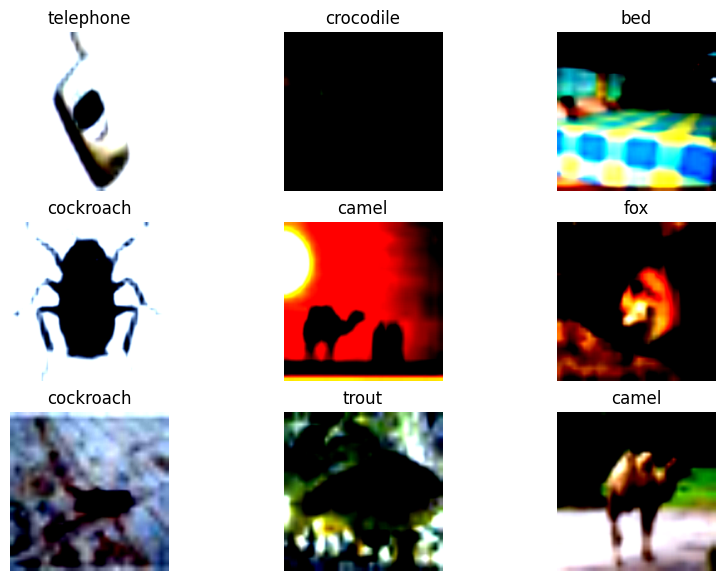

In [21]:
# Plotting Images Randomnly from train dataset in (3*3) grid -> with labels attached
ROWS = 3
COLUMNS = 3

plt.figure(figsize=(10,7))
for i in range(1, ROWS*COLUMNS+1):
    rand_idx = random.randint(0, len(train_dataset) - 1)
    img, label = train_dataset[rand_idx]

    plt.subplot(ROWS, COLUMNS, i)
    plt.title(class_names[label])
    plt.imshow(img.permute(1,2,0).numpy())

    plt.axis(False)

In [22]:
# Verify the type of train_featues and labels
print(f'Features: {type(train_features)}, Labels: {type(train_labels)}')

Features: <class 'torch.Tensor'>, Labels: <class 'torch.Tensor'>


In [23]:
# Defining ImageClassifier with 100 classes and sending to GPU for faster processing
model = ImageClassifier(num_classes= len(class_names)).to(device)
print(next(model.parameters()).device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0


In [ ]:
# Purpose:-> Retrain the Model
# model = ImageClassifier(num_classes= len(class_names)).to(device)
# model.load_state_dict(torch.load(f=MODEL_PATH))

In [25]:
# Save the best model based on the validation loss during the training process
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='checkpoints', filename='file', save_last=True)
# Logs the learning rate at each epoch interval.
lr_monitor = LearningRateMonitor(logging_interval='epoch')
# Global seed set to 0
seed_everything(0)
# Optimized for faster training
trainer = Trainer(max_epochs=10, accelerator='gpu',
                  precision="16-mixed", # Mixed-precision training technique to optimize the use of GPU
                  accumulate_grad_batches=2,
                  enable_progress_bar=True,
                  num_sanity_val_steps=0,
                  callbacks=[lr_monitor, checkpoint_callback],
#                   limit_train_batches=100, # Limit the training batches (1563) -> 100
#                   limit_val_batches=10 # Limit the validation batches (313) -> 10
                  )

trainer.fit(model, train_loader, test_loader)

INFO:lightning_fabric.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type               | Params
---------------------------------------------------
0 | loss_fn     | CrossEntropyLoss   | 0     
1 | ac

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [26]:
# During training, monitor the model's performance on a separate validation set
# Used to adjust the model's hyperparameters or learning rate accordingly.
val_res = trainer.validate(model=model, dataloaders=test_loader)
print(val_res)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.8309999704360962     │
│      val_loss_epoch       │    0.7602232694625854     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.7602232694625854, 'val_acc_epoch': 0.8309999704360962}]


In [27]:
# After Training, Evaluate the model's performance on unseen data.
test_res = trainer.test(dataloaders=test_loader)
print(test_res)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints/file-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/checkpoints/file-v1.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8309999704360962     │
│      test_loss_epoch      │    0.7602232694625854     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.7602232694625854, 'test_acc_epoch': 0.8309999704360962}]


In [28]:
# Saving the model to the desired place
print(f'Saving model to: {MODEL_PATH}')
torch.save(obj=model.state_dict(), f=MODEL_PATH)

Saving model to: models/HybridModel.pth


In [29]:
# Loading the model with previously saved model weights
loaded_model = ImageClassifier(num_classes= len(class_names)).to(device)
loaded_model.load_state_dict(torch.load(f=MODEL_PATH))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-d

<All keys matched successfully>

In [30]:
# Getting the Ordered State Dict from the model
state_dict1 = model.state_dict()
state_dict2 = loaded_model.state_dict()

In [31]:
# Convert the Ordered State Dict Dictionaries to tensors
state_dict1_tensor = torch.cat([v.view(-1) for v in state_dict1.values()]).to(device)
state_dict2_tensor = torch.cat([v.view(-1) for v in state_dict2.values()]).to(device)

In [32]:
# Checking the place where the tensor resides (GPU/CUDA)
print(state_dict1_tensor.device, state_dict2_tensor.device)

cuda:0 cuda:0


In [33]:
# Compare the state_dicts of the two models
is_same = torch.equal(state_dict1_tensor, state_dict2_tensor)

if is_same:
    print("The Ordered State Dicts of the two models are the same.")
else:
    print("The Ordered State Dicts of the two models are different.")

The Ordered State Dicts of the two models are the same.
